In [1]:
import pandas as pd
from pandas import option_context

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
from typing import List, Tuple, Dict, Union, Optional
import random
import glob
random.seed(0)
import dataframe_image as dfi
import re
from collections import Counter

from scipy.stats import normaltest, ttest_ind, tukey_hsd

from generation_exp import get_best_checkpoint

pd.set_option('max_colwidth', 400) # avoid trimming cells
pd.set_option('display.max_columns', None) # avoid trunting columns
pd.set_option('display.max_rows', None) # avoid truncating rows

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
exp_seeds = [23, 42, 1984]
resource_path = Path('resources/models')
plot_path = Path(f'resources/plots')
plot_path.mkdir(parents=True, exist_ok=True)

In [3]:
name_mapping = {
    'gen_setting': 'Generation Setting',
    'bart_base': 'BART-base',
    'bart_large': 'BART-large',
    't5_small': 'T5-small',
    't5v11_small': 'T5v1.1-small',
    't5_base': 'T5-base',
    't5v11_base': 'T5v1.1-base',
    't5_lm_small': 'T5-small-LM',
    't5_lm_base': 'T5-base-LM',
    'model': 'Model',
    'qc_turn_level': '% of inquisitive responses',
    'default': 'Default', 
    'qu_ctxt_aug1': 'CTX. AUG. + ATTN. BIAS = 1', 
    'qu_ctxt_aug5': 'CTX. AUG.',
    'pos_sent_ctxt_aug5': 'CTX. AUG.',
    'neg_sent_ctxt_aug5': 'CTX. AUG.',
    'neu_sent_ctxt_aug5': 'CTX. AUG.',
    'hedging_contrast_ctxt_aug5': 'CTX. AUG.',
    'hedging_management_ctxt_aug5': 'CTX. AUG.',
    'hedging_evasion_ctxt_aug5': 'CTX. AUG.',
    'hedging_contrast': '% of contrastive hedge responses',
    'hedging_management': '% of management hedge responses',
    'hedging_evasion': '% of evasion hedge responses',
    'pos_sents': '% of positive responses',
    'neg_sents': '% of negative responses',
    'neu_sents': '% of neutral responses',
    'SI(BART)': "$\mathregular{SI_{BART}}$",
    'SI(MASS)': "$\mathregular{SI_{MASS}}$",
    'SI(T5)': "$\mathregular{SI_{T5}}$",
    'MLM+PS': 'MLM+PS',
    'MLM': 'MLM',
    'PS': 'PS',
    'bart_small_rndm': "No PT",
    'rouge1_s': 'ROUGE-1 (src)',
    'bleu_t': 'BLEU',
    'ppl_mean': 'PPL',
    "intra_dist1": "Dist-1 (intra)",
    "inter_dist1": "Dist-1 (inter)",
    "self_bleu": "Self-BLEU",
    "bleu_t": "BLEU",
    "rouge1_t": "ROUGE-1",
    "rouge2_t": "ROUGE-2",
    "rougeL_t": "ROUGE-L",
    "bleu_d": "BLEU (dialog)",
    "rouge1_d": "ROUGE-1 (dialog)",
    "rouge2_d": "ROUGE-2 (dialog)",
    "rougeL_d": "ROUGE-L (dialog)",
    "bleu_k": "BLEU (knowledge)",
    "rouge1_k": "ROUGE-1 (knowledge)",
    "rouge2_k": "ROUGE-2 (knowledge)",
    "rougeL_k": "ROUGE-L (knowledge)",
    "bleu_s": "BLEU (source)",
    "rouge1_s": "ROUGE-1 (source)",
    "rouge2_s": "ROUGE-2 (source)",
    "rougeL_s": "ROUGE-L (source)",
    "meteor_t": "METEOR",
    "novelty_s_1gram": "% novel N-grams",
    "uniq": "% unique responses",
}

### Inspect generated outputs

In [4]:
def parse_generations_file_stem(stem: str) -> Tuple:
    """
    generations_test_freq_seed=0_ml=40_lp=1.0_ns=1_bs=4_ds=1_temp=0.7_tk=0_tp=0.9.txt
    """
    parts = stem.split('_')
    gen_seed = int(parts[3].split('=')[-1])
    gen_setting = None
    if len(parts) == 12 and parts[-1] == 'tp=0.9':
        # ['generations', 'test', 'freq', 'seed=42', 'ml=40', 'lp=1.0', 'ns=1', 'bs=4', 'ds=1', 'temp=0.7', 'tk=0', 'tp=0.9']
        gen_setting = 'default'
    else:
        # 'xatt=5-dialog' -> 'xatt=5-dialog', 'ctxt=5-train', 'pos', 'sents-10' -> 'ctxt=5-train_pos_sents-10'
        gen_setting = '_'.join(parts[12:])
    return (gen_setting, gen_seed)
    
def quick_lc(file: Union[str, Path]) -> int:
    with open(file, 'rb') as f:
        return sum(1 for line in f)
    
def read_lines(file: Union[str, Path], line_indices: Optional[List[int]]=None) -> List[str]:
    lines = []
    with open(file, 'r', encoding='utf8') as f:
        for i, line in enumerate(f):
            if line_indices and i not in line_indices:
                pass
            else:
                lines.append(line.strip())
    return lines

def sample_line_indices(lc: int, n: int) -> List[int]:
    return random.sample(range(lc), n)
    
def get_outputs_dataframe(model_path: Path, sample_n: int = 10) -> pd.DataFrame:
    # checkpoint_dir = get_best_checkpoint(model_path)
    file_list = list((model_path / f'outputs').glob('generation*'))
    
    if sample_n > 0:
        expected_lc = quick_lc(file_list[0])
        sample_lines = sample_line_indices(expected_lc, sample_n)
        print(sample_lines)
    else:
        sample_lines = None
    
    d = {}
    for file in file_list:
        d[parse_generations_file_stem(file.stem)] = read_lines(file, sample_lines)
    # load dictionary into dataframe, splitting the key tuple into a multiIndex
    df = pd.DataFrame(d.values(), index=pd.MultiIndex.from_tuples(d.keys(), names=['gen_setting', 'seed']))
    df = df.sort_values(by=['gen_setting', 'seed'], ascending=True)
    return df

# model_path = Path('resources/models/seed_42/ft/bart_small_rndm')
model_path = Path('resources/models/seed_42/ft/bart_small_rndm')
sampled_outputs = get_outputs_dataframe(model_path, sample_n=10)
sampled_outputs.head(10)

[1824, 409, 4506, 4012, 3657, 2286, 1679, 8935, 1424, 6912]


0  \
gen_setting                seed                                           
ctxt=1-train_questions-10  0                    Yeah. Do you know that?   
                           42              Yeah, that is a lot of money   
                           284                 Yeah, I don't know that.   
                           983   Yeah, I wonder if they are the players   
                           8630            Yeah, that is a lot of money   
ctxt=5-hedging_contrast-12 0                 Yeah, it is a lot of money   
                           42                Yeah, it is a lot of money   
                           284               Yeah, that is pretty cool.   
                           983                  Yeah. Do you know that?   
                           8630      Yeah, I think it is a lot of money   

                                                                                               1  \
gen_setting                seed                                                                    
ctxt=1-train_questions-10  0                                                  I don't know that.   
                           42         That's crazy. Did you know that the highest paid football?   
                           284                      I agree. Did you know that the highest paid?   
                           983                 That's crazy. Did you know that the highest paid?   
                           8630            I don't know that. Do you know that the highest paid?   
ctxt=5-hedging_contrast-12 0             I don't know that. Did you know that the highest court?   
                           42    That's crazy. Did you know that the highest paid football game?   
                           284           I don't know that. Did you know that the highest court?   
                           983             I agree. Did you know that the highest paid football?   
                           8630            I agree. Did you know that the highest paid football?   

                                                                                              2  \
gen_setting                seed                                                                   
ctxt=1-train_questions-10  0                      I don't know that. Did you know that the NFL?   
                           42                     I don't know that. Did you know that the NFL?   
                           284                              I agree. Did you know that the NFL?   
                           983                              I agree. Did you know that the NFL?   
                           8630      I don't know that. Did you know that the Apple is average?   
ctxt=5-hedging_contrast-12 0                      I don't know that. Did you know that the NFL?   
                           42    I don't know that. Did you know that the Superbook is average?   
                           284                         I don't know that. Do you know that NFL?   
                           983                    I don't know that. Did you know that the NFL?   
                           8630                I agree. Did you know that the Apper is average?   

                                                                                                                                   3  \
gen_setting                seed                                                                                                        
ctxt=1-train_questions-10  0                                                            I didn't know that. Do you know that the US?   
                           42                          I don't know that. Did you know that the Super Bill Maybe the South Patriots?   
                           284                                             That's interesting. Did you know that the South Patriots?   
                           983   I agree. Did you know that the South Patriots was the Super Bill M

### Emprical analysis for question context controlled generation

In [5]:
INDEX_LEVELS = ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']

def get_all_results(exp_seed_runs=[23], resource_path=resource_path, results_dir='results_topchat_kgd_test_freq', build_dataframe=True):
    """
    given a list of experiment seeds and the resource path directory, gather up all the results csv files we can find
    """
    model_c = Counter()
    result_c = Counter()
    
    dfs = []
    for seed in exp_seed_runs:
        exp_dir = resource_path / f'seed_{seed}'
        model_names = [p.name for p in Path(exp_dir / 'ft').iterdir()]
        print(f'\nFound {len(model_names)} models for seed {seed}: {model_names}')
        model_c.update(model_names)
        
        results_path = exp_dir / results_dir
        if build_dataframe:
            result_file_list = list(results_path.glob(f'*.csv'))
            print(f'Found {len(result_file_list)} results files in corresponding results directory ({results_path})')
            result_c.update(map(str, result_file_list))
            df = load_results_dataframe(result_file_list, verbose=False)
            dfs.append(df)

    print('\nFound models for the following experiment runs:\n')
    print(model_c)
    
    # print('\nFound results for the following experiment runs:\n')
    # print(result_c)

    df = pd.concat(dfs, axis=0) if len(dfs) else None
    if df is not None:
        print(f'Dataframe has {len(df)} entries')

    return df
    
def parse_results_filepath(file: Path) -> Tuple:
    """parses information from results file name such as, e.g.
    - bart_base-qu_ctxt_aug1.csv
    - bart_small-SI_bart-qu_ctxt_aug5.csv 
    - bart_small-SI_mass-0.25-qu_ctxt_aug1.csv
    """
    exp_seed = int(file.parts[2].split('_')[-1])
    parts = file.stem.split('-')
    model, chkpt, pt_config, exp_setting, gen_setting = None, None, None, None, None
    # print(parts)
    # if len(parts) == 2:
    #     model, gen_setting = parts # bart_base-qu_ctxt_aug1.csv -> model name, generation setting
    if len(parts) == 3: # ['bart_base', 'best', 'xa_knowledge+qu_ctxt_aug5'] 
        model, chkpt, gen_setting = parts
    elif len(parts) == 4: # ['bart_small', 'MLM', 'best', 'baseline']
        model, pt_config, chkpt, gen_setting = parts
    else:
        raise RuntimeError(f'Failed to parse file with: {parts}')

    if gen_setting == 'baseline': # rename baseline as default
        gen_setting = 'default'
        
    if not pt_config:
        pt_config = model
    else: # tidy up names
        pt_config = pt_config.replace('_bart5_25', '(BART5:25)')
        pt_config = pt_config.replace('_bart5_50', '(BART5:50)')
        pt_config = pt_config.replace('_bart5_75', '(BART5:75)')
        pt_config = pt_config.replace('_bart', '(BART)')
        pt_config = pt_config.replace('_t5', '(T5)')
        pt_config = pt_config.replace('_mass', '(MASS)')
        pt_config = pt_config.replace('_', '+')

    if chkpt and chkpt != 'best':
        chkpt = int(chkpt.split('_')[-1])
    
    ft_data_size = 1.0 # default values assumed
    if exp_setting is not None and exp_setting[0].isdigit():       
        ft_data_size = float(exp_setting)
    
    return exp_seed, pt_config, ft_data_size, chkpt, gen_setting    
        
def flatten(l: List[List]) -> List:
    """flattens a list of lists"""
    return [item for sublist in l for item in sublist]

def scale_values(df):
    bleu_cols = [col for col in df.columns if 'bleu' in col]
    print(f"scaling {bleu_cols} between [0,1]")
    for col in bleu_cols:
        df[col] = df[col] / 100
    return df

def load_results_dataframe(result_file_list: List, verbose: bool = False) -> pd.DataFrame:
    
    dfs = []
    for file in result_file_list:    
        if verbose:
            print(f'Loading data from {file} ...')
        df = pd.read_csv(file, sep=',', header=0, index_col=None)
        if len(df) != 5:
            print(f'Skipping {file} only has {len(df)} entries!')
        else:
            df['exp_seed'], df['model'], df['ft_data_size'], df['chkpt'], df['gen_setting'] = parse_results_filepath(file)
            df['file'] = file.stem
            df = df.rename(columns={'self_bleu_t': 'self_bleu'}) # temp fix
            # if not any(df['seed'].isnull()):
            #     print(f"check seed in {file}. Found value of {df['seed']}")
            # df['gen_seed'] = df['seed'].astype('int32')
            dfs.append(df)

    # check that all dfs have same length
    df_lengths = list(map(len,dfs))
    if len(set(df_lengths)) == 1:
        print(f"{len(dfs)} DFs have length {df_lengths[0]}")
    else:
        print(f"[!] DF lengths are not consistent! {df_lengths}")
    
    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    # standardise concatenated dataframe
    df.set_index(INDEX_LEVELS, inplace=True)
    df = df.sort_values(by=INDEX_LEVELS, ascending=True)
    df = scale_values(df)
    
    if verbose:
        print(f'\nResults table contains:')
        for col_name in df.columns.to_list():
              print(f'\t{col_name}')
        print(f'Dataframe index:')
        print(f'\t{df.index}')
        print(f'Dataframe has {len(df)} entries')
    return df

def get_detailed_info_on_complex_dataframe(df):
    
#     print('Index Columns:')
#     for name in df.index.names:
#         print(f'\t{df.index.get_level_values(name).unique()}')
#     print()
    
    print('Index columns value counts:\n')
    for name in df.index.names:
        print(f'{df.index.get_level_values(name).value_counts()}')
    print()

    print(f'Dataframe columns:')
    print(f'\t{df.columns}')
    print()
    return

In [6]:
public_model_results_df = get_all_results(exp_seeds, results_dir='results/topchat_kgd_test_freq-public_models', build_dataframe=True)
get_detailed_info_on_complex_dataframe(public_model_results_df)
public_model_results_df.head(8)


Found 41 models for seed 23: ['bart_small-SI_mass-squad_v2', 'bart_small-SI_bart5_50', 'bart_small-SI_t5-squad', 'bart_small_rndm', 't5v11_base', 'scratch', 'bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-MLM', 'bart_small-SI_PS', 'bart_small-SI_t5-squad_v2', 'bart_small-SI_t5-enc-squad', 'bart_small-SI_bart5_75', 'bart_small-SI_mass-0.75', 'bart_base', 'bart_small-SI_mass-0.25', 'bart_small-PS', 'bart_small-SI_bart-enc-squad', 'bart_small-MLM_PS', 'bart_small-SI_bart-0.75', 'bart_small-SI_bart-squad_v2', 't5_small', 'bart_large', 't5_lm_small', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-SI_mass-enc-squad', 'bart_small-MLM_PS_DR', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'mass_base', 'bart_small-SI_mass-squad', 'bart_small-SI_bart5_25', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 't5v11_small', 'bart_small-SI_mass', 'bart_small-SI_bart-squad']
Found 68 results files i

model_name_or_path  \
exp_seed model     gen_setting                chkpt ft_data_size seed                                          
23       bart_base default                    best  1.0          0     resources/models/seed_23/ft/bart_base   
                                                                 42    resources/models/seed_23/ft/bart_base   
                                                                 284   resources/models/seed_23/ft/bart_base   
                                                                 983   resources/models/seed_23/ft/bart_base   
                                                                 8630  resources/models/seed_23/ft/bart_base   
                   hedging_contrast_ctxt_aug5 best  1.0          0     resources/models/seed_23/ft/bart_base   
                                                                 42    resources/models/seed_23/ft/bart_base   
                                                                 284   resources/models/seed_23/ft/bart_base   

                                                                       checkpoint_dir  \
exp_seed model     gen_setting                chkpt ft_data_size seed                   
23       bart_base default                    best  1.0          0                NaN   
                                                                 42               NaN   
                                                                 284              NaN   
                                                                 983              NaN   
                                                                 8630             NaN   
                   hedging_contrast_ctxt_aug5 best  1.0          0                NaN   
                                                                 42               NaN   
                                                                 284              NaN   

                                                                       batch_size  \
exp_seed model     gen_setting                chkpt ft_data_size seed               
23       bart_base default                    best  1.0          0            120   
                                                                 42           120   
                                                                 284          120   
                                                                 983          120   
                                                                 8630         120   
                   hedging_contrast_ctxt_aug5 best  1.0          0            120   
                                                                 42           120   
                                                                 284          120   

                                                                                                            test_file  \
exp_seed model     gen_setting                chkpt ft_data_size seed                                                   
23       bart_base default                    best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                                 42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                                 284   resources/data/Topical-Chat/KGD/test_freq.json   
                                                                 983   resources/data/Topical-Chat/KGD/test_freq.json   
                                                                 8630  resources/data/Topical-Chat/KGD/test_freq.json   
                   hedging_contrast_ctxt_aug5 best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                                 42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                                 284   resources/data/Topical-Chat/KGD/test_freq.json   

                

In [7]:
small_model_results_df = get_all_results(exp_seeds, results_dir='results/topchat_kgd_test_freq-bart_small', build_dataframe=True)
get_detailed_info_on_complex_dataframe(small_model_results_df)
small_model_results_df.head(8)


Found 41 models for seed 23: ['bart_small-SI_mass-squad_v2', 'bart_small-SI_bart5_50', 'bart_small-SI_t5-squad', 'bart_small_rndm', 't5v11_base', 'scratch', 'bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-MLM', 'bart_small-SI_PS', 'bart_small-SI_t5-squad_v2', 'bart_small-SI_t5-enc-squad', 'bart_small-SI_bart5_75', 'bart_small-SI_mass-0.75', 'bart_base', 'bart_small-SI_mass-0.25', 'bart_small-PS', 'bart_small-SI_bart-enc-squad', 'bart_small-MLM_PS', 'bart_small-SI_bart-0.75', 'bart_small-SI_bart-squad_v2', 't5_small', 'bart_large', 't5_lm_small', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-SI_mass-enc-squad', 'bart_small-MLM_PS_DR', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'mass_base', 'bart_small-SI_mass-squad', 'bart_small-SI_bart5_25', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 't5v11_small', 'bart_small-SI_mass', 'bart_small-SI_bart-squad']
Found 120 results files 

model_name_or_path  \
exp_seed model gen_setting                chkpt ft_data_size seed                                               
23       MLM   default                    best  1.0          0     resources/models/seed_23/ft/bart_small-MLM   
                                                             42    resources/models/seed_23/ft/bart_small-MLM   
                                                             284   resources/models/seed_23/ft/bart_small-MLM   
                                                             983   resources/models/seed_23/ft/bart_small-MLM   
                                                             8630  resources/models/seed_23/ft/bart_small-MLM   
               hedging_contrast_ctxt_aug5 best  1.0          0     resources/models/seed_23/ft/bart_small-MLM   
                                                             42    resources/models/seed_23/ft/bart_small-MLM   
                                                             284   resources/models/seed_23/ft/bart_small-MLM   

                                                                   checkpoint_dir  \
exp_seed model gen_setting                chkpt ft_data_size seed                   
23       MLM   default                    best  1.0          0                NaN   
                                                             42               NaN   
                                                             284              NaN   
                                                             983              NaN   
                                                             8630             NaN   
               hedging_contrast_ctxt_aug5 best  1.0          0                NaN   
                                                             42               NaN   
                                                             284              NaN   

                                                                   batch_size  \
exp_seed model gen_setting                chkpt ft_data_size seed               
23       MLM   default                    best  1.0          0            120   
                                                             42           120   
                                                             284          120   
                                                             983          120   
                                                             8630         120   
               hedging_contrast_ctxt_aug5 best  1.0          0            120   
                                                             42           120   
                                                             284          120   

                                                                                                        test_file  \
exp_seed model gen_setting                chkpt ft_data_size seed                                                   
23       MLM   default                    best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                             42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                             284   resources/data/Topical-Chat/KGD/test_freq.json   
                                                             983   resources/data/Topical-Chat/KGD/test_freq.json   
                                                             8630  resources/data/Topical-Chat/KGD/test_freq.json   
               hedging_contrast_ctxt_aug5 best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                             42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                             284   resources/data/Topical-Chat/KGD/test_freq.json   

                                                                   data_seed  \
exp_seed model gen_setting                chkpt

In [8]:
print(len(public_model_results_df))
print(len(small_model_results_df))
df = pd.concat([public_model_results_df, small_model_results_df])
print(len(df))

1055
1800
2855


In [9]:
# # SI+PS is not available for all exp seeds, so drop it.
# df = df.drop('SI+PS', level=1, axis=0)
# # df = df.iloc[df.index.get_level_values('ft_data_size') == 1.0] # select only those entries which use 100% fine-tuning data
# # df = df[df.index.get_level_values('chkpt') == 'best']# select only those entries which use the best model (not checkpoints)
# get_detailed_info_on_complex_dataframe(df)

### generate tables highlighting metric differences

In [10]:
baselines_settings = list(set(['default', 'xa_dialog', 'xa_knowledge']))
print('BASELINES:', baselines_settings)
experiment_settings = list(set([key[2] for key in df.index if key[2] not in baselines_settings]))
print('EXPERIMENT SETTINGS:', experiment_settings)

def calculate_diffs(df, target, baseline):
    df.loc[target][:] = df.loc[target] - df.loc[baseline]
    return df

def highlight_max(s):
    return np.where(s == np.nanmax(s.to_numpy()), f"font-weight:bold;", None)

def style_nums(v):
    if v < 0:
        return 'color:red;'
    elif v > 0:
        return 'color:MediumSeaGreen;'
    else:
        return None

def style_dataframe(df, show_only=None):
    """formats a given dataframe with baseline rows and performance diff rows"""
    s = df.style # init style object from df

    # remove alternating row colors
    s.set_table_styles([
        {
            "selector":"thead",
            "props":[("background-color","white")]
        },
        {
            "selector":"tbody tr:nth-child(even)",
            "props":[("background-color","white")]
        },
    ])
    
    # grey out baseline rows border-bottom: 1px solid black;
    s.apply(lambda s: np.where(s.index.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    s.apply_index(lambda s: np.where(s.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    
    # color values (elementwise)
    s.applymap(style_nums, subset=(experiment_settings, slice(None)))

    # find max from each row
    # s.apply(highlight_max, axis=1)
    
    # format numbers
    s.format(lambda x: f'{x*100:.2f}')
    # s.format(lambda x: x*100).format(precision=2)
    # , subset=[:, 1:]
    
    if show_only is not None:
        print(f'Showing only {show_only} ...')
        ignore = [gs for gs in s.index if gs not in show_only]
        s.hide(subset=ignore, axis=0, level=None, names=False)

    # format index names
    # s.format_index(lambda x: name_mapping.get(x), axis=1, na_rep='MISS')
  
    return s

def aggregate_values_for_target_metric(df, agg_ops: Dict = {'qc_sent_level': np.mean}):
    
    print(f'Dataframe has length: {len(df)}')
    
    if set(df.index.get_level_values('ft_data_size').values) != set([1.0]):
        print(f"[!] Found multiple fine-tuning data sizes: {set(df.index.get_level_values('ft_data_size').values)}")
    if set(df.index.get_level_values('chkpt').values) != set(['best']):
        print(f"[!] Found multiple checkpoint values: {set(df.index.get_level_values('chkpt').values)}")
               
    # aggregate values
    print(f'Dataframe has index columns: {df.index.names}')
    group_by_cols = ['model', 'gen_setting']
    print(f'Will group by: {group_by_cols}')
    df = df.groupby(group_by_cols, as_index=True).agg(agg_ops)

    # apply sorting
    df = df.sort_values(group_by_cols, ascending=[1]*len(group_by_cols))

    # apply filtering on rows (if necessary)
    # df = df.drop(['xa_dialog', 'xa_knowledge'], level=1, axis=0)
    # df = df.iloc[df.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
    # df = df.iloc[~df.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level

    return df

def reshape(df, level=1, subset: List = None):
    """
    reshape from vertical to horizontal format
    """
    df = df.stack().unstack(0)
    df = df.reset_index(level=level, drop=True) # remove the dummy index 'gen_setting'
    # dfa = dfa.droplevel(level=0, axis=1) # remove metric index (if necessary)
    # dfa.columns = dfa.columns.droplevel() # remove metric index (if necessary)

    if subset is not None:
        df = df[subset]
    # apply filtering on columns (if necessary)
#     keep_cols = ['MLM+PS', 'MLM-RW', 'MLM-RW(T5)', 'MLM-RW+PS']
#     drop_cols = [col for col in dfa.columns if col not in keep_cols]
#     dfa = dfa.drop(columns=drop_cols, errors='ignore')
    
    # reorder columns
    print('Dataframe has columns:', list(df.columns))
    all_reordered_cols = [
        'bart_small_rndm',
        'MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR', 
        'SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)',
        'bart_base', 
        'bart_large', 
        't5_small', 
        't5v11_small', 
        't5_lm_small',
        't5_base', 
        't5v11_base', 
        't5_lm_base',
        'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)',
        ]
    avail_resorted_cols = []
    for col in all_reordered_cols:
        if col in set(list(df.columns)):
            avail_resorted_cols.append(col)
            
# #     if set(reordered_cols) != set(list(dfa.columns)):
#         print('DF columns doesn\'t match provided for resorting. Check the resorted columns!')
#     else:
    print('Sorting columns as:', avail_resorted_cols)
    df = df[avail_resorted_cols]
    
    return df 

# # compute customised dataframe with experimental row showing difference between experimental result and the baseline setting
def make_diff_df(df):
    df = calculate_diffs(df, 'qu_ctxt_aug1', 'default')
    df = calculate_diffs(df, 'qu_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'pos_sent_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'neg_sent_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'xa_dialog+qu_ctxt_aug5', 'xa_dialog')
    df = calculate_diffs(df, 'xa_knowledge+qu_ctxt_aug5', 'xa_knowledge')
    df = calculate_diffs(df, 'hedging_contrast_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'hedging_management_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'hedging_evasion_ctxt_aug5', 'default')
    return df


# mini_bart_MLM = ['MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR']
# mini_bart = ['SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)',]
# # mini_roberta = ['roberta_small_shared', 'roberta_small']
# public_enc_dec = ['bart_base', 't5_small', 't5_lm_small']
# public_enc = ['bert_base', 'roberta_base', 'bert_base_shared', 'roberta_base_shared']

# qdf = aggregate_values_for_target_metric(df, agg_ops={'qc_turn_level': [np.mean, np.std]})
# qdf = reshape(qdf, subset=['bart_base'])
# qdf.stack(0).unstack(0).reset_index(level=1, drop=True)['mean', 'bart_base']
# qdf.stack(0).unstack(0).reset_index(level=1, drop=True)['std', 'bart_base']
# qdf = make_diff_df(qdf)
# qdf = style_dataframe(qdf, show_only=['default', 'qu_ctxt_aug1', 'qu_ctxt_aug5'])
# qdf
# # print(qdf.to_latex(hrules=True, convert_css=True))


BASELINES: ['xa_knowledge', 'xa_dialog', 'default']
EXPERIMENT SETTINGS: ['xa_knowledge+qu_ctxt_aug5', 'neg_sent_ctxt_aug5', 'pos_sent_ctxt_aug5', 'qu_ctxt_aug5', 'qu_ctxt_aug1', 'hedging_contrast_ctxt_aug5', 'xa_dialog+qu_ctxt_aug5', 'hedging_evasion_ctxt_aug5', 'hedging_management_ctxt_aug5']


In [11]:
# generate results tables
qdf = aggregate_values_for_target_metric(df, agg_ops={'qc_turn_level': np.mean})
qdf = reshape(qdf, subset=['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base'])
qdf = make_diff_df(qdf)
qdf = style_dataframe(qdf, show_only=['default', 'qu_ctxt_aug1', 'qu_ctxt_aug5'])
qdf
# print(qdf.to_latex(hrules=True, convert_css=True))

Dataframe has length: 2855
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base']
Sorting columns as: ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base']
Showing only ['default', 'qu_ctxt_aug1', 'qu_ctxt_aug5'] ...


model,bart_base,bart_large,t5_small,t5v11_small,t5_lm_small,t5v11_base
gen_setting,,,,,,
default,27.32,23.02,28.52,30.18,27.18,28.26
qu_ctxt_aug1,10.29,3.17,0.61,4.14,1.87,-0.85
qu_ctxt_aug5,27.99,11.84,1.40,10.35,3.26,-8.34


In [12]:
sdf = aggregate_values_for_target_metric(df, agg_ops={'pos_sents': np.mean})
sdf = reshape(sdf, subset=['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base'])
sdf = make_diff_df(sdf)
sdf = style_dataframe(sdf, show_only=['default', 'pos_sent_ctxt_aug5'])
sdf

Dataframe has length: 2855
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base']
Sorting columns as: ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base']
Showing only ['default', 'pos_sent_ctxt_aug5'] ...


model,bart_base,bart_large,t5_small,t5v11_small,t5_lm_small,t5v11_base
gen_setting,,,,,,
default,60.66,65.68,58.85,53.07,58.55,58.79
pos_sent_ctxt_aug5,17.60,7.36,11.48,2.96,1.99,10.78


In [13]:
sdf = aggregate_values_for_target_metric(df, agg_ops={'neg_sents': np.mean})
sdf = reshape(sdf, subset=['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base'])
sdf = make_diff_df(sdf)
sdf = style_dataframe(sdf, show_only=['default', 'neg_sent_ctxt_aug5'])
sdf

Dataframe has length: 2855
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['bart_base', 't5_small', 't5v11_small', 't5_lm_small', 'bart_large', 't5v11_base']
Sorting columns as: ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base']
Showing only ['default', 'neg_sent_ctxt_aug5'] ...


model,bart_base,bart_large,t5_small,t5v11_small,t5_lm_small,t5v11_base
gen_setting,,,,,,
default,39.34,34.32,41.15,46.93,41.45,41.21
neg_sent_ctxt_aug5,-7.16,-3.77,2.92,-3.33,3.66,-2.72


In [14]:
# generate results tables
qdf = aggregate_values_for_target_metric(df, agg_ops={'qc_turn_level': np.mean})
qdf = reshape(qdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm'])
qdf = make_diff_df(qdf)
qdf = style_dataframe(qdf, show_only=['default', 'qu_ctxt_aug1', 'qu_ctxt_aug5'])
qdf
# print(qdf.to_latex(hrules=True, convert_css=True))

Dataframe has length: 2855
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm']
Sorting columns as: ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)']
Showing only ['default', 'qu_ctxt_aug1', 'qu_ctxt_aug5'] ...


model,bart_small_rndm,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5)
gen_setting,,,,,,,
default,54.18,35.24,50.39,40.61,50.79,44.87,54.04
qu_ctxt_aug1,4.21,6.86,2.46,5.46,3.22,0.18,1.19
qu_ctxt_aug5,-6.00,11.59,5.94,3.83,7.12,-5.42,-5.48


In [15]:
sdf = aggregate_values_for_target_metric(df, agg_ops={'pos_sents': np.mean})
sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm'])
sdf = make_diff_df(sdf)
sdf = style_dataframe(sdf, show_only=['default', 'pos_sent_ctxt_aug5'])
sdf
# print(sdf.to_latex(hrules=True, convert_css=True))

Dataframe has length: 2855
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm']
Sorting columns as: ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)']
Showing only ['default', 'pos_sent_ctxt_aug5'] ...


model,bart_small_rndm,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5)
gen_setting,,,,,,,
default,29.24,39.19,29.17,34.52,31.46,35.65,34.00
pos_sent_ctxt_aug5,11.97,7.12,5.11,15.33,6.71,6.47,13.93


In [16]:
sdf = aggregate_values_for_target_metric(df, agg_ops={'neg_sents': np.mean})
sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm'])
sdf = make_diff_df(sdf)
sdf = style_dataframe(sdf, show_only=['default', 'neg_sent_ctxt_aug5'])
sdf

Dataframe has length: 2855
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm']
Sorting columns as: ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)']
Showing only ['default', 'neg_sent_ctxt_aug5'] ...


model,bart_small_rndm,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5)
gen_setting,,,,,,,
default,70.76,60.81,70.83,65.48,68.54,64.35,66.00
neg_sent_ctxt_aug5,-8.68,0.13,1.97,-8.13,1.29,-3.14,-6.21


In [17]:
# sdf = aggregate_values_for_target_metric(df, agg_ops={'hedging_contrast': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'hedging_contrast_ctxt_aug5'])
# sdf

In [18]:
# sdf = aggregate_values_for_target_metric(df, agg_ops={'hedging_evasion': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'hedging_evasion_ctxt_aug5'])
# sdf

In [19]:
# sdf = aggregate_values_for_target_metric(df, agg_ops={'hedging_management': np.mean})
# sdf = reshape(sdf, subset=['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',])
# sdf = make_diff_df(sdf)
# sdf = style_dataframe(sdf, show_only=['default', 'hedging_management_ctxt_aug5'])
# sdf

## Statistical Significance

In [20]:
# adapted from https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/

def check_is_normal(array, threshold=0.05):
    value, p = normaltest(array)
    if p >= 0.05:
        print(f'It is likely that {array} is normal')
    else:
        print(f'It is unlikely that {array} is normal')

def run_tests(values1, values2, threshold=0.05):
    """
    Following Hazarika et al., 2022 (https://arxiv.org/abs/2106.06411),
    we compute Two-tailed unpaired t-test and Tukey's HSD between 
    baseline (default generation) and experimental settings (e.g. with CTX. AUG.)
    """
    # print(values1.shape)
    # print(values2.shape)
    # check_is_normal(values1)
    # check_is_normal(values2)

    # print('Comparing Means for Gaussian Results...')
    
    value, pvalue = ttest_ind(values1, values2, equal_var=True)
    print(f"Two-tailed unpaired t-test: {value}, {pvalue}")
    if pvalue > threshold:
        print(f'\tSamples are likely drawn from the same distributions (fail to reject H0) p={threshold}')
    else:
        print(f'\tSamples are likely drawn from DIFFERENT distributions (reject H0) p={threshold} ***')
    
    # # Welch’s t-test (different variances)
    # value, pvalue = ttest_ind(values1, values2, equal_var=False)
    # print(f"Welch's t-test (unequal variances): {value}, {pvalue}")
    # if pvalue > threshold:
    #     print(f'\tSamples are likely drawn from the same distributions (fail to reject H0) p={threshold}')
    # else:
    #     print(f'\tSamples are likely drawn from different distributions (reject H0) p={threshold}')

    # non-Gaussian data
    # value, pvalue = ks_2samp(values1, values2)
    # print(value, pvalue)
    # if pvalue > 0.05:
    #     print('Samples are likely drawn from the same distributions (fail to reject H0)')
    # else:
    #     print('Samples are likely drawn from different distributions (reject H0)')

    # print(tukey_hsd(values1, values2))
    tuk = tukey_hsd(values1, values2)
    # print(dir(tuk))
    # print(tuk.confidence_interval())
    value = tuk.statistic[0,1]
    pvalue = tuk.pvalue[0,1]

    print(f"Tukey's HSD: {value}, {pvalue})")
    if pvalue > threshold:
        print(f'\tSamples are likely drawn from the same distributions (fail to reject H0) p={threshold}')
    else:
        print(f'\tSamples are likely drawn from DIFFERENT distributions (reject H0) p={threshold} ***')
    

def compute_significance(df, baseline_setting = "default", exp_setting = "qu_ctxt_aug5", tgt_metric = "qc_turn_level", threshold=0.05):
    
    exp_seeds = df.index.unique(level=0)
    models = df.index.unique(level=1)
    
    for model in models:
        print()
        for exp_seed in exp_seeds:
            print(f"Model: {model}, Seed run: {exp_seed}")
            bsl = df.iloc[(df.index.get_level_values(0) == exp_seed) & (df.index.get_level_values(1) == model) & (df.index.get_level_values(2) == baseline_setting)][tgt_metric].to_numpy()
            exp = df.iloc[(df.index.get_level_values(0) == exp_seed) & (df.index.get_level_values(1) == model) & (df.index.get_level_values(2) == exp_setting)][tgt_metric].to_numpy()    
            run_tests(bsl, exp, threshold=threshold)

    return
    
# compute_significance(df, "default", "qu_ctxt_aug5", threshold=0.001)



## Plots

In [23]:
def contrastive_gen_settings_barplot(df, models, gen_settings, tgt_metric, save_as=None): #data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):

    # setup figure, axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.2 * len(models), 2.5))
    
    # subset dataframe
    dfs = df.iloc[(df.index.get_level_values(1).isin(models)) & (df.index.get_level_values(2).isin(gen_settings))].reset_index()
    # dfs.head()
    # print(len(dfs))

    sns.barplot(
        data=dfs, 
        x="model", 
        y=tgt_metric, 
        hue="gen_setting", 
        order=models, 
        hue_order=gen_settings,
        alpha=0.7, 
        capsize=.05,
        errwidth=0.6,
        errcolor=".2",
        linewidth=0.6, 
        edgecolor=".2", 
        palette='tab10',
        ax=ax,
    )
    
    # make plot pretty
    ax.set(xlabel=None, ylabel=name_mapping.get(tgt_metric, tgt_metric), title=None)

    labels = [name_mapping.get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()] # https://stackoverflow.com/questions/11244514/modify-tick-label-text
    ax.set_xticklabels(labels)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    
    # make legend pretty
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        labels = [name_mapping.get(label, label) for label in labels]
        ax.legend(handles, labels, title="Generation Settings", frameon=False, framealpha=1, facecolor='white')
        # ax.legend(handles, labels, title="Generation Settings", frameon=True, framealpha=0.6, facecolor='white')
    
    if save_as is not None:
        print(f'saving to {save_as}.* ...')
        # plt.savefig(f'{save_as}.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'{save_as}.png', bbox_inches='tight', dpi=300)

    return

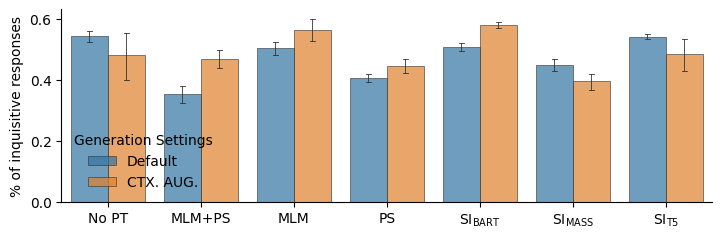

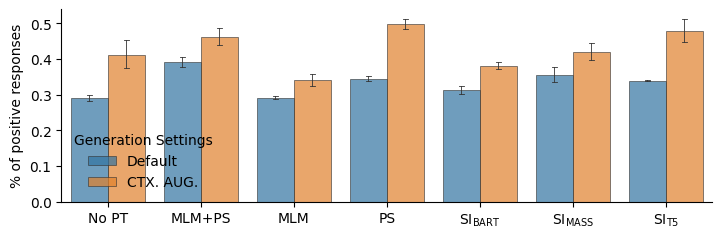

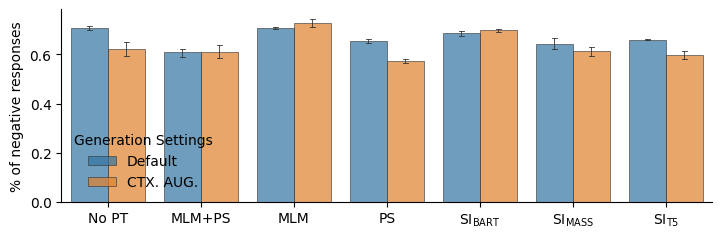

In [26]:
contrastive_gen_settings_barplot(df, ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)'], ['default', 'qu_ctxt_aug5'], tgt_metric="qc_turn_level")
contrastive_gen_settings_barplot(df, ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)'], ['default', 'pos_sent_ctxt_aug5'], tgt_metric="pos_sents")
contrastive_gen_settings_barplot(df, ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)'], ['default', 'neg_sent_ctxt_aug5'], tgt_metric="neg_sents")



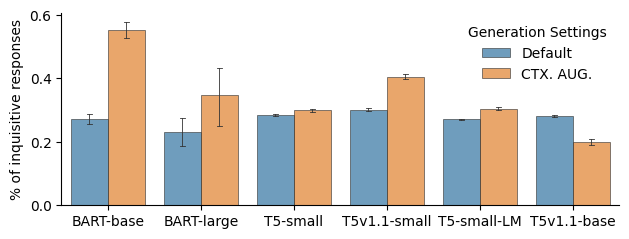

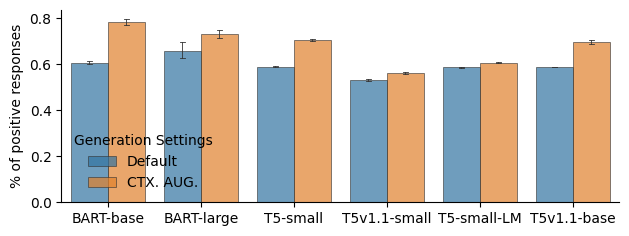

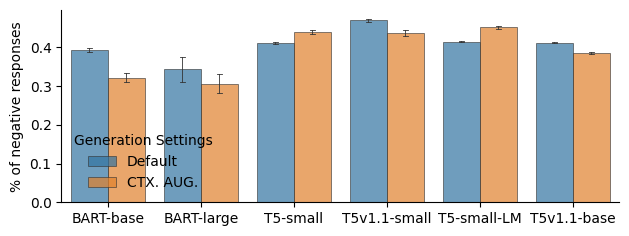

In [27]:
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'qu_ctxt_aug5'], tgt_metric="qc_turn_level")
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'pos_sent_ctxt_aug5'], tgt_metric="pos_sents")
contrastive_gen_settings_barplot(df, ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], ['default', 'neg_sent_ctxt_aug5'], tgt_metric="neg_sents")


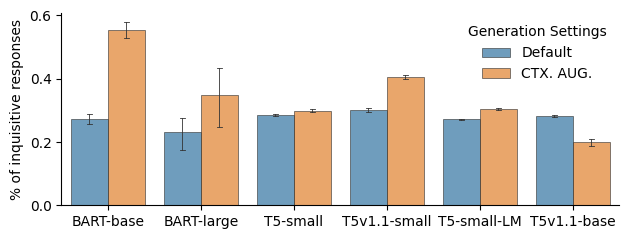

In [24]:

# contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'qu_ctxt_aug5'], tgt_metric="qc_turn_level", save_as='resources/plots/public_models_qc_default-qu_ctxt_aug5')
# contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'pos_sent_ctxt_aug5'], tgt_metric="pos_sents", save_as='resources/plots/public_models_pos_default-pos_sent_ctxt_aug5')
# contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'neg_sent_ctxt_aug5'], tgt_metric="neg_sents", save_as='resources/plots/public_models_neg_default-neg_sent_ctxt_aug5')
# contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'hedging_contrast_ctxt_aug5'], tgt_metric="hedging_contrast", save_as='resources/plots/public_models_neg_default-hedging_contrast_ctxt_aug5')
# contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'hedging_management_ctxt_aug5'], tgt_metric="hedging_management", save_as='resources/plots/public_models_neg_default-hedging_management_ctxt_aug5')
# contrastive_gen_settings_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], ['default', 'hedging_evasion_ctxt_aug5'], tgt_metric="hedging_evasion", save_as='resources/plots/public_models_neg_default-hedging_evasion_ctxt_aug5')


---
# Performance metrics

In [34]:
perf_metrics = {
    'uniq': np.mean,
    'ppl_mean': np.mean,
    'intra_dist1': np.mean,
    'inter_dist1': np.mean,
    'self_bleu': np.mean,
    'bleu_t': np.mean,
    'bleu_d': np.mean,
    'bleu_k': np.mean,
    'rouge1_t': np.mean,
    'rouge2_t': np.mean,
    'rougeL_t': np.mean,
    'rouge1_d': np.mean,
    'rouge2_d': np.mean,
    'rougeL_d': np.mean,
    'rouge1_k': np.mean,
    'rouge2_k': np.mean,
    'rougeL_k': np.mean,
    'rouge1_s': np.mean,
    'rouge2_s': np.mean,
    'rougeL_s': np.mean,    
    'meteor_t': np.mean,
    'novelty_s_1gram': np.mean,
    # 'novelty_s_2gram': np.mean,
    # 'novelty_s_3gram': np.mean,
    # 'novelty_s_4gram': np.mean,
}
    
# produce table    
pdf = aggregate_values_for_target_metric(df[df.index.get_level_values(2) == 'default'], agg_ops=perf_metrics)
# pdf
pdf = reshape(pdf, level=0,
             )
pdf

Dataframe has length: 240
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['MLM', 'MLM+PS', 'PS', 'SI(BART)', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)', 'SI(MASS)', 'SI(T5)', 'bart_base', 'bart_large', 'bart_small_rndm', 't5_lm_small', 't5_small', 't5v11_base', 't5v11_small']
Sorting columns as: ['bart_small_rndm', 'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base', 'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)']


model,bart_small_rndm,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5),bart_base,bart_large,t5_small,t5v11_small,t5_lm_small,t5v11_base,SI(BART5:25),SI(BART5:50),SI(BART5:75)
uniq,0.573083,0.764979,0.667446,0.683714,0.681515,0.701114,0.702798,0.938680,0.681875,0.903218,0.839287,0.909079,0.928774,0.714411,0.695113,0.709101
ppl_mean,50.873901,59.090450,54.910057,57.258738,53.712539,60.619647,58.639697,465.268887,368.853371,75.644252,55.139069,105.036684,147.255665,58.711281,55.624065,57.137539
intra_dist1,0.905299,0.922566,0.927964,0.930684,0.927132,0.920619,0.928778,0.918275,0.893695,0.884180,0.886434,0.874311,0.903601,0.928921,0.928442,0.930837
inter_dist1,0.007675,0.019852,0.017378,0.018284,0.017378,0.015457,0.016906,0.023745,0.016563,0.020902,0.018866,0.020357,0.022203,0.017689,0.017567,0.018242
self_bleu,0.856336,0.743968,0.790209,0.775711,0.785421,0.779356,0.783501,0.506803,0.659578,0.609619,0.638646,0.604480,0.537187,0.779936,0.785186,0.772564
bleu_t,0.010704,0.032050,0.033260,0.030964,0.032872,0.029331,0.035702,0.067035,0.047925,0.049732,0.045878,0.051184,0.059344,0.033960,0.033115,0.033873
bleu_d,0.000011,0.000073,0.000073,0.000054,0.000068,0.000043,0.000085,0.000086,0.000082,0.000077,0.000048,0.000090,0.000062,0.000076,0.000075,0.000074
bleu_k,0.010057,0.151465,0.157072,0.146982,0.153029,0.112501,0.155355,0.120466,0.085992,0.123331,0.117634,0.127286,0.119156,0.159624,0.151526,0.156090
rouge1_t,0.164461,0.203474,0.207485,0.200913,0.205644,0.201561,0.212412,0.278650,0.228794,0.243044,0.234070,0.244899,0.263954,0.208263,0.207631,0.207765
rouge2_t,0.032421,0.063348,0.064717,0.062631,0.064690,0.061060,0.067227,0.118477,0.085222,0.092955,0.087854,0.094279,0.108520,0.064901,0.064560,0.065268


In [36]:
def contrastive_model_barplot(df, models, gen_setting, tgt_metric, save_as=None): #data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):

    # setup figure, axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1*len(models), 1.5))
    
    # subset dataframe
    dfs = df.iloc[(df.index.get_level_values(1).isin(models)) & (df.index.get_level_values(2) == gen_setting)].reset_index()

    sns.barplot(
        data=dfs, 
        x="model", 
        y=tgt_metric, 
        order=models, 
        hue_order=models,
        alpha=0.7, 
        capsize=.05,
        errwidth=0.6,
        errcolor=".2",
        linewidth=0.6, 
        edgecolor=".2", 
        palette='tab10',
        ax=ax,
    )
    
    # make plot pretty
    ax.set(xlabel=None, ylabel=None, title=name_mapping.get(tgt_metric, tgt_metric))

    labels = [name_mapping.get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()] # https://stackoverflow.com/questions/11244514/modify-tick-label-text
    ax.set_xticklabels(labels)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    
    # make legend pretty
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        labels = [name_mapping.get(label, label) for label in labels]
        ax.legend(handles, labels, title="Generation Settings", frameon=False)
    
    if save_as is not None:
        print(f'saving to {save_as}.* ...')
        # plt.savefig(f'{save_as}.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'{save_as}.png', bbox_inches='tight', dpi=300)

    return

/net/cephfs/data/tkew/tmp/9895407/ipykernel_3529/1042055385.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1*len(models), 1.5))


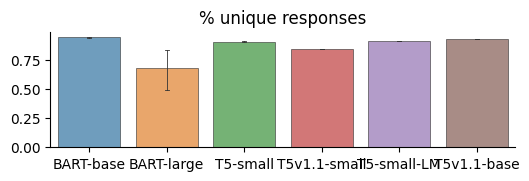

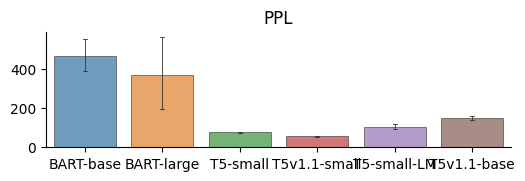

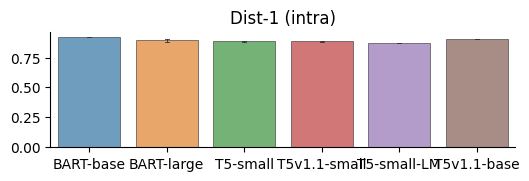

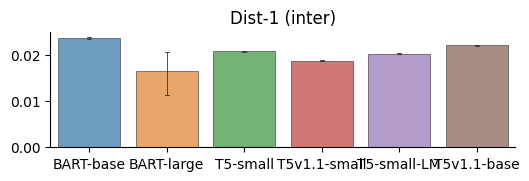

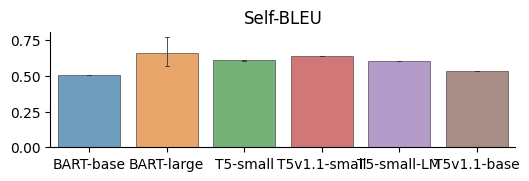

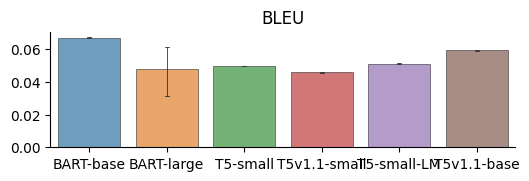

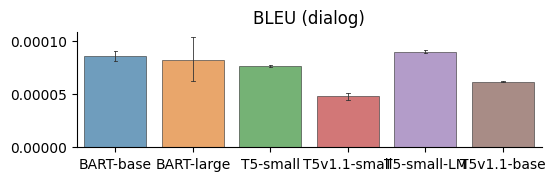

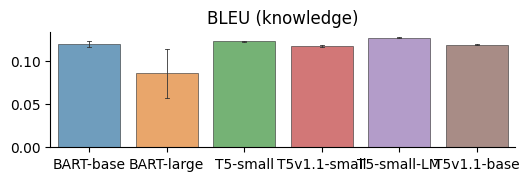

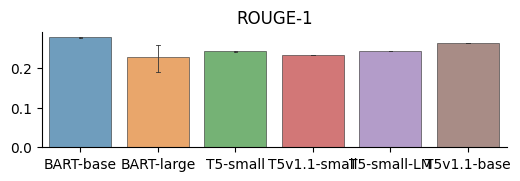

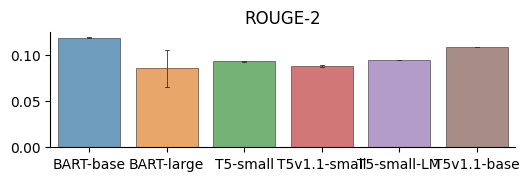

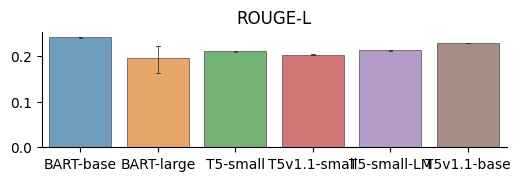

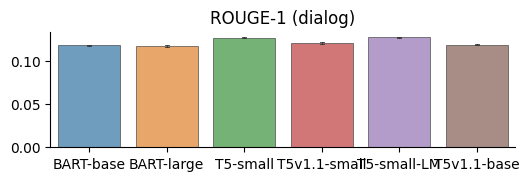

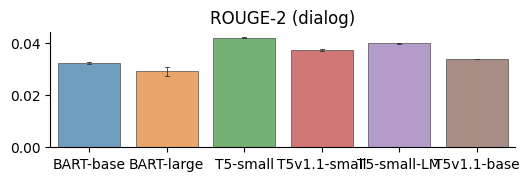

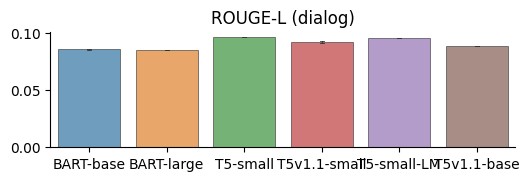

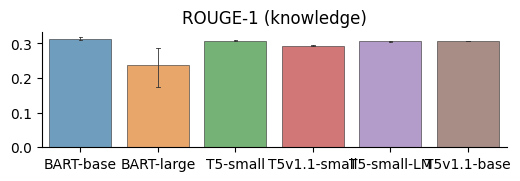

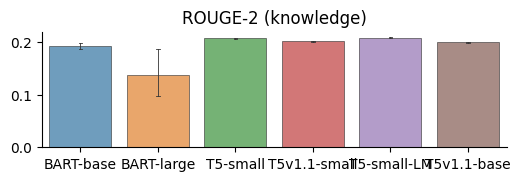

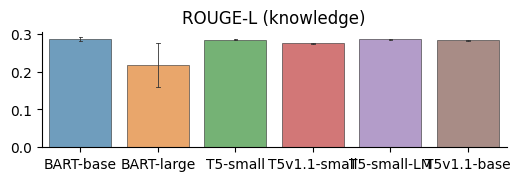

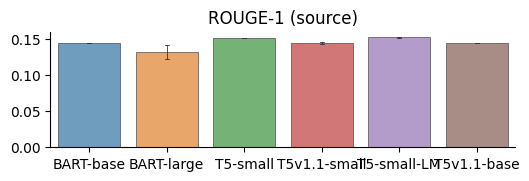

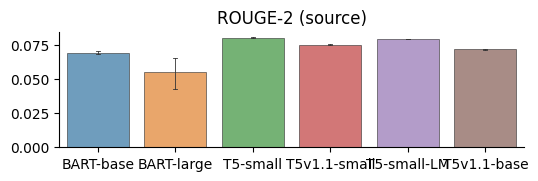

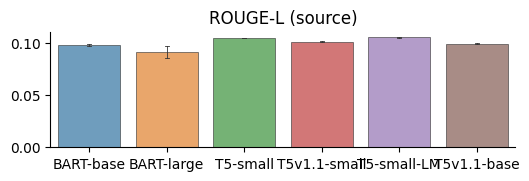

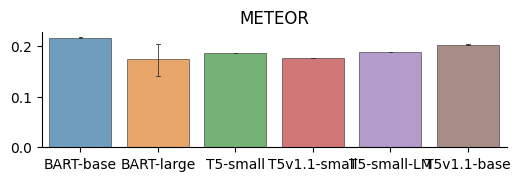

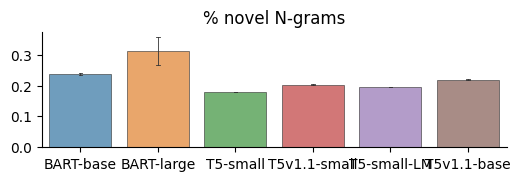

In [37]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(
        df, 
        ['bart_base', 'bart_large', 't5_small', 't5v11_small', 't5_lm_small', 't5v11_base'], 
        'default', 
        tgt_metric=metric, 
        # save_as=f"resources/plots/public_models_default_{metric}"
    )

saving to resources/plots/bart_small_default_uniq.* ...
saving to resources/plots/bart_small_default_ppl_mean.* ...
saving to resources/plots/bart_small_default_intra_dist1.* ...
saving to resources/plots/bart_small_default_inter_dist1.* ...
saving to resources/plots/bart_small_default_self_bleu.* ...
saving to resources/plots/bart_small_default_bleu_t.* ...
saving to resources/plots/bart_small_default_bleu_d.* ...
saving to resources/plots/bart_small_default_bleu_k.* ...
saving to resources/plots/bart_small_default_rouge1_t.* ...
saving to resources/plots/bart_small_default_rouge2_t.* ...
saving to resources/plots/bart_small_default_rougeL_t.* ...
saving to resources/plots/bart_small_default_rouge1_d.* ...
saving to resources/plots/bart_small_default_rouge2_d.* ...
saving to resources/plots/bart_small_default_rougeL_d.* ...
saving to resources/plots/bart_small_default_rouge1_k.* ...
saving to resources/plots/bart_small_default_rouge2_k.* ...
saving to resources/plots/bart_small_defaul

/net/cephfs/data/tkew/tmp/9802588/ipykernel_4654/656160257.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 1.5))


saving to resources/plots/bart_small_default_meteor_t.* ...
saving to resources/plots/bart_small_default_novelty_s_1gram.* ...


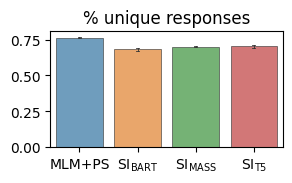

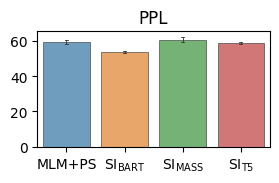

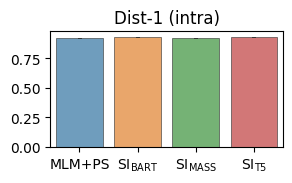

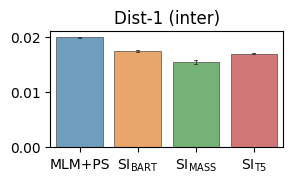

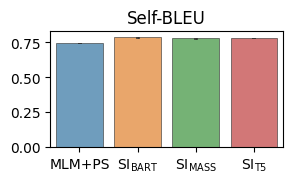

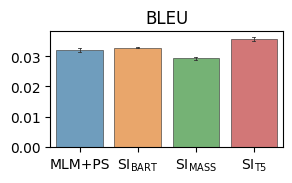

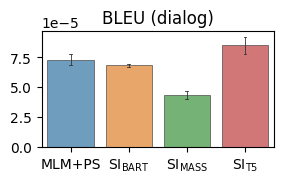

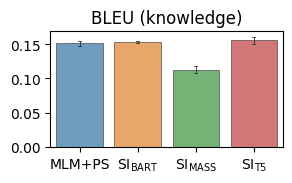

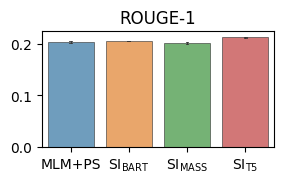

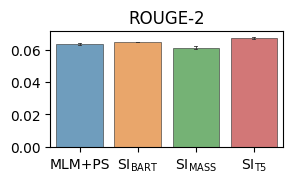

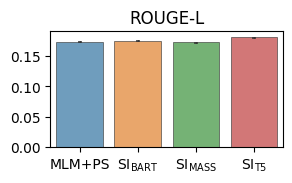

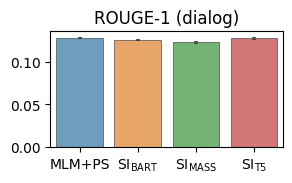

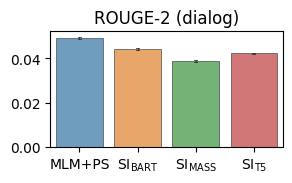

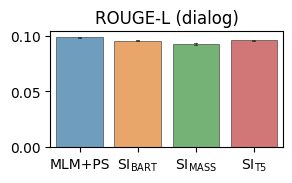

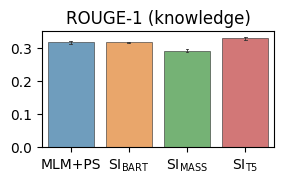

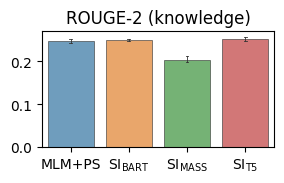

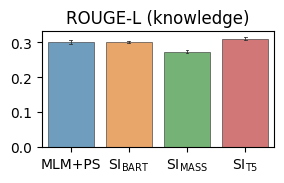

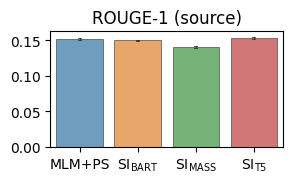

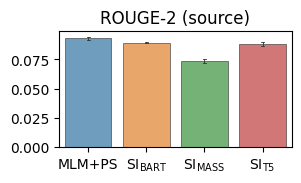

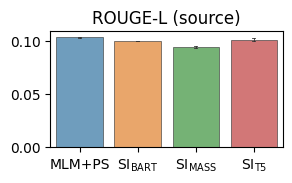

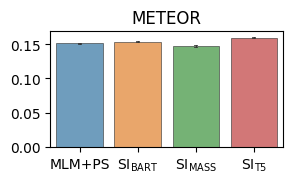

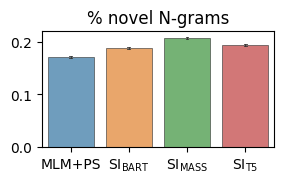

In [111]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(df, ['MLM+PS','SI(BART)', 'SI(MASS)', 'SI(T5)'], 'default', tgt_metric=metric, save_as=f"resources/plots/bart_small_default_{metric}")


saving to resources/plots/bart_small_xa_dialog_uniq.* ...
saving to resources/plots/bart_small_xa_dialog_ppl_mean.* ...
saving to resources/plots/bart_small_xa_dialog_intra_dist1.* ...
saving to resources/plots/bart_small_xa_dialog_inter_dist1.* ...
saving to resources/plots/bart_small_xa_dialog_self_bleu.* ...
saving to resources/plots/bart_small_xa_dialog_bleu_t.* ...
saving to resources/plots/bart_small_xa_dialog_bleu_d.* ...
saving to resources/plots/bart_small_xa_dialog_bleu_k.* ...
saving to resources/plots/bart_small_xa_dialog_rouge1_t.* ...
saving to resources/plots/bart_small_xa_dialog_rouge2_t.* ...
saving to resources/plots/bart_small_xa_dialog_rougeL_t.* ...
saving to resources/plots/bart_small_xa_dialog_rouge1_d.* ...
saving to resources/plots/bart_small_xa_dialog_rouge2_d.* ...
saving to resources/plots/bart_small_xa_dialog_rougeL_d.* ...
saving to resources/plots/bart_small_xa_dialog_rouge1_k.* ...
saving to resources/plots/bart_small_xa_dialog_rouge2_k.* ...
saving to r

/net/cephfs/data/tkew/tmp/9802588/ipykernel_4654/656160257.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 1.5))


saving to resources/plots/bart_small_xa_dialog_meteor_t.* ...
saving to resources/plots/bart_small_xa_dialog_novelty_s_1gram.* ...


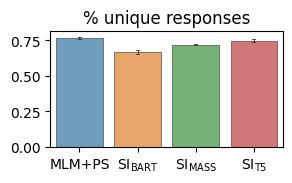

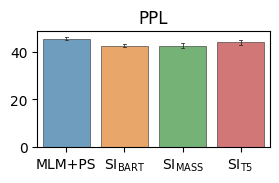

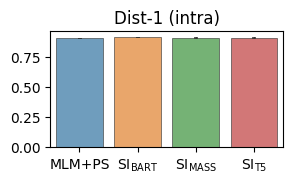

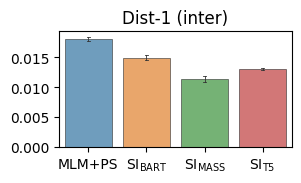

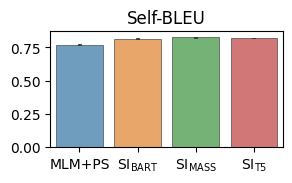

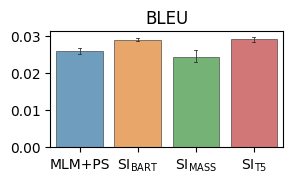

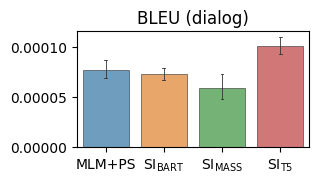

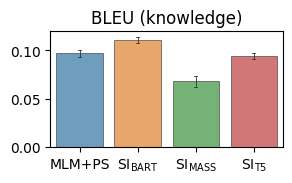

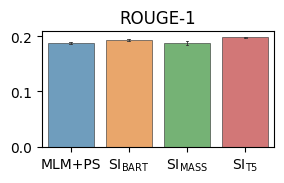

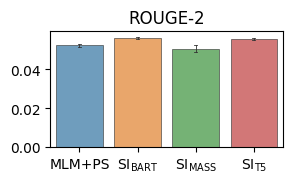

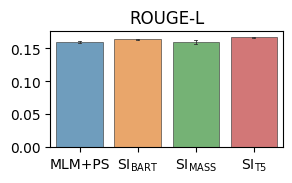

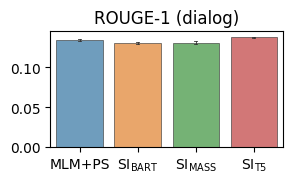

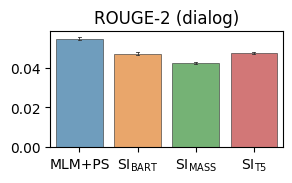

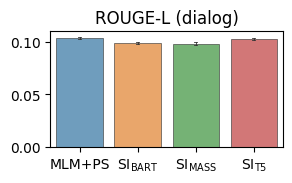

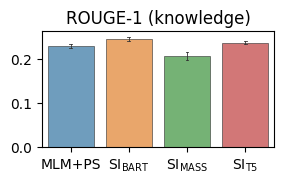

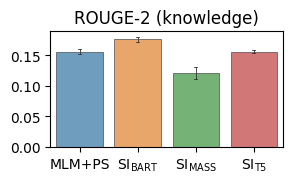

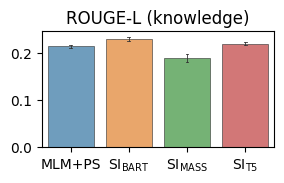

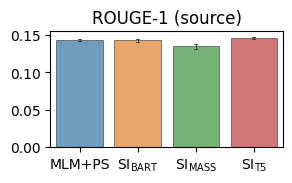

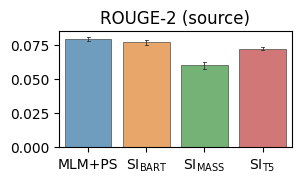

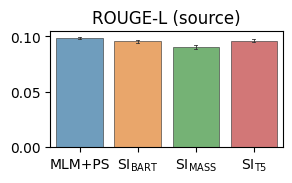

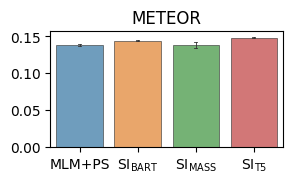

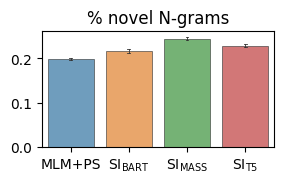

In [112]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(df, ['MLM+PS','SI(BART)', 'SI(MASS)', 'SI(T5)'], 
                              'xa_dialog', tgt_metric=metric, save_as=f"resources/plots/bart_small_xa_dialog_{metric}")

saving to resources/plots/bart_small_xa_knowledge_uniq.* ...
saving to resources/plots/bart_small_xa_knowledge_ppl_mean.* ...
saving to resources/plots/bart_small_xa_knowledge_intra_dist1.* ...
saving to resources/plots/bart_small_xa_knowledge_inter_dist1.* ...
saving to resources/plots/bart_small_xa_knowledge_self_bleu.* ...
saving to resources/plots/bart_small_xa_knowledge_bleu_t.* ...
saving to resources/plots/bart_small_xa_knowledge_bleu_d.* ...
saving to resources/plots/bart_small_xa_knowledge_bleu_k.* ...
saving to resources/plots/bart_small_xa_knowledge_rouge1_t.* ...
saving to resources/plots/bart_small_xa_knowledge_rouge2_t.* ...
saving to resources/plots/bart_small_xa_knowledge_rougeL_t.* ...
saving to resources/plots/bart_small_xa_knowledge_rouge1_d.* ...
saving to resources/plots/bart_small_xa_knowledge_rouge2_d.* ...
saving to resources/plots/bart_small_xa_knowledge_rougeL_d.* ...
saving to resources/plots/bart_small_xa_knowledge_rouge1_k.* ...
saving to resources/plots/ba

/net/cephfs/data/tkew/tmp/9802588/ipykernel_4654/656160257.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 1.5))


saving to resources/plots/bart_small_xa_knowledge_meteor_t.* ...
saving to resources/plots/bart_small_xa_knowledge_novelty_s_1gram.* ...


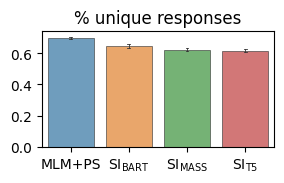

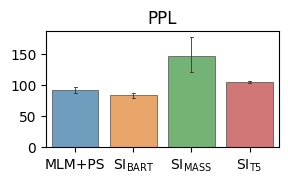

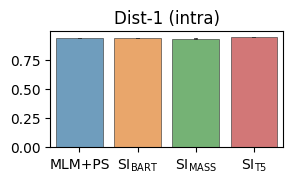

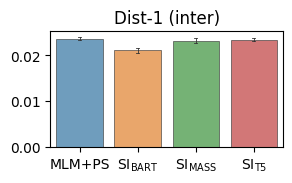

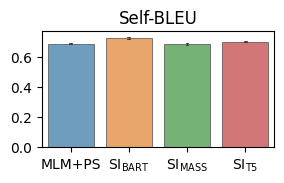

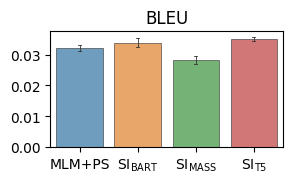

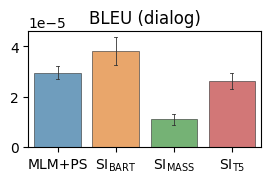

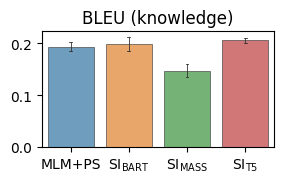

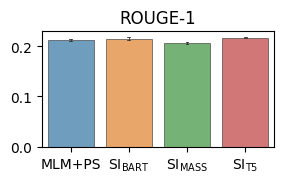

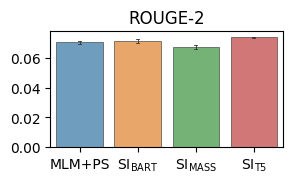

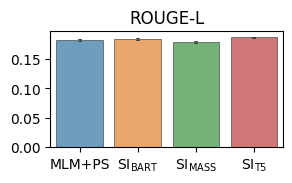

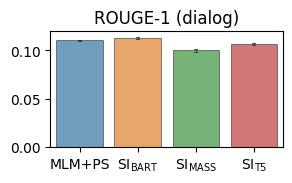

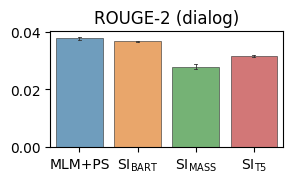

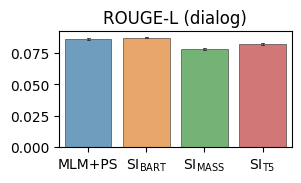

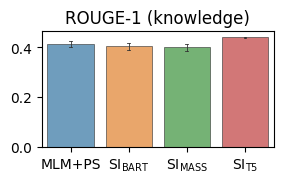

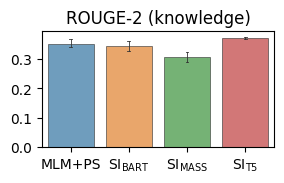

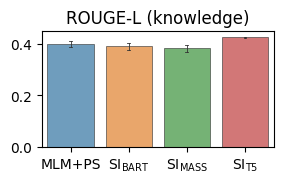

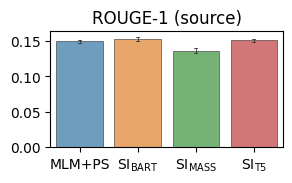

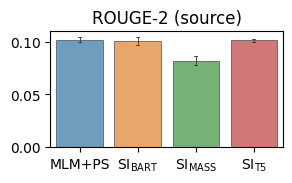

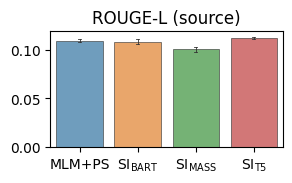

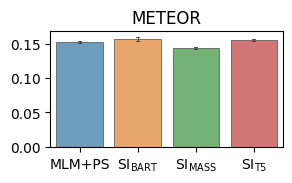

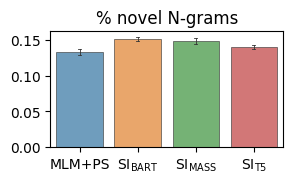

In [113]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(df, ['MLM+PS','SI(BART)', 'SI(MASS)', 'SI(T5)'], 
                              'xa_knowledge', tgt_metric=metric, save_as=f"resources/plots/bart_small_xa_knowledge_{metric}")
    

In [114]:
# print(df['rouge1_t'].describe())
# print(df['bleu_t'].describe())

In [115]:
# df[df['rouge1_t'] >= 0.28]

---

# Validation inference runs


In [73]:
vdf = get_all_results([23, 42, 1984], results_dir='results/topchat_kgd_valid_freq_221014', build_dataframe=True)


Found 41 models for seed 23: ['bart_small-SI_mass-squad_v2', 'bart_small-SI_bart5_50', 'bart_small-SI_t5-squad', 'bart_small_rndm', 't5v11_base', 'scratch', 'bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-MLM', 'bart_small-SI_PS', 'bart_small-SI_t5-squad_v2', 'bart_small-SI_t5-enc-squad', 'bart_small-SI_bart5_75', 'bart_small-SI_mass-0.75', 'bart_base', 'bart_small-SI_mass-0.25', 'bart_small-PS', 'bart_small-SI_bart-enc-squad', 'bart_small-MLM_PS', 'bart_small-SI_bart-0.75', 'bart_small-SI_bart-squad_v2', 't5_small', 'bart_large', 't5_lm_small', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-SI_mass-enc-squad', 'bart_small-MLM_PS_DR', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'mass_base', 'bart_small-SI_mass-squad', 'bart_small-SI_bart5_25', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 't5v11_small', 'bart_small-SI_mass', 'bart_small-SI_bart-squad']
Found 90 results files i

In [74]:
vdf.head(8)

model_name_or_path  \
exp_seed model    gen_setting chkpt ft_data_size seed                                                   
23       SI(BART) default     7260  1.0          0     resources/models/seed_23/ft/bart_small-SI_bart   
                                                 42    resources/models/seed_23/ft/bart_small-SI_bart   
                                                 284   resources/models/seed_23/ft/bart_small-SI_bart   
                                                 983   resources/models/seed_23/ft/bart_small-SI_bart   
                                                 8630  resources/models/seed_23/ft/bart_small-SI_bart   
                              14520 1.0          0     resources/models/seed_23/ft/bart_small-SI_bart   
                                                 42    resources/models/seed_23/ft/bart_small-SI_bart   
                                                 284   resources/models/seed_23/ft/bart_small-SI_bart   

                                                         checkpoint_dir  \
exp_seed model    gen_setting chkpt ft_data_size seed                     
23       SI(BART) default     7260  1.0          0      checkpoint-7260   
                                                 42     checkpoint-7260   
                                                 284    checkpoint-7260   
                                                 983    checkpoint-7260   
                                                 8630   checkpoint-7260   
                              14520 1.0          0     checkpoint-14520   
                                                 42    checkpoint-14520   
                                                 284   checkpoint-14520   

                                                       batch_size  \
exp_seed model    gen_setting chkpt ft_data_size seed               
23       SI(BART) default     7260  1.0          0            120   
                                                 42           120   
                                                 284          120   
                                                 983          120   
                                                 8630         120   
                              14520 1.0          0            120   
                                                 42           120   
                                                 284          120   

                                                                                             test_file  \
exp_seed model    gen_setting chkpt ft_data_size seed                                                    
23       SI(BART) default     7260  1.0          0     resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 42    resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 284   resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 983   resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 8630  resources/data/Topical-Chat/KGD/valid_freq.json   
                              14520 1.0          0     resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 42    resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 284   resources/data/Topical-Chat/KGD/valid_freq.json   

                                                       data_seed  \
exp_seed model    gen_setting chkpt ft_data_size seed              
23       SI(BART) default     7260  1.0          0             0   
                                                 42            0   
                                                 284           0   
                                                 983           0   
                                                 8630          0   
                              14520 1.0          0   

Dataframe has length: 1350
90
60
90
40


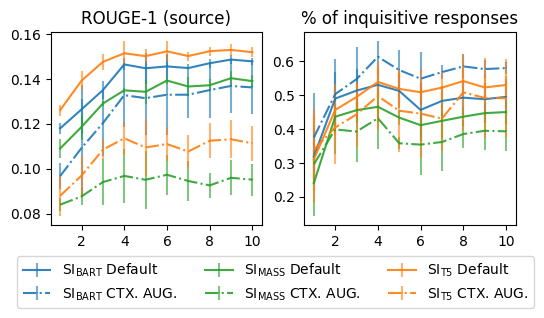

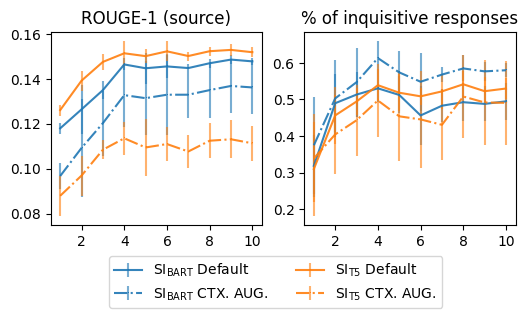

In [79]:
# plt.style.use('classic')
# plt.rcParams.update('IPython_default')
# sns.set_theme()
# sns.set_style("white")

def convert_steps_to_epochs(steps: List[int], max_epochs: int = 10) -> List[int]:
    if len(steps) == max_epochs:
        return list(range(1, max_epochs+1))
    else:
        raise NotImplementedError

def plot_validation_scores_ablation(df, agg_ops={}, gen_settings_subset=None, models_subset=None, save_as=None, verbose=False):

    styles = ['-', '--', '-.']
    markers = ['^', 'p', '*']
    cmap = cm.get_cmap('tab10')(np.linspace(0, 1, 10)) # hack to get the colormap as a list of colors (https://stackoverflow.com/questions/70314497/convert-colormap-to-list)
    # print(cmap)

    line_styles = {
        'SI(BART)': cmap[0],
        'SI(T5)': cmap[1],
        'SI(MASS)': cmap[2],
        # 'default': markers[0],
        # 'qu_ctxt_aug1': markers[1],
        # 'qu_ctxt_aug5': markers[2],
        'default': styles[0],
        'qu_ctxt_aug1': styles[1],
        'qu_ctxt_aug5': styles[2],
    }
    
    group_by_cols = ['model', 'gen_setting', 'chkpt']
    
    if verbose:
        print(f'INDEX COLUMNS: {df.index.names}')
        print(f'GROUPING BY: {group_by_cols}')
        
    df = df.groupby(group_by_cols, as_index=True).agg(agg_ops)
    print(len(df))
    # subset
    df = df.iloc[df.index.get_level_values('gen_setting').isin(gen_settings_subset)]
    df = df.iloc[df.index.get_level_values('model').isin(models_subset)]
    print(len(df))
    
    # initialize figure
    fig, axes = plt.subplots(nrows=1, ncols=len(agg_ops), figsize=(3*len(agg_ops), 2.5), sharex=True)

    if len(agg_ops) == 1: # non-iterable axes version
        print('plotting non-iterable')
        for model_idx, (model, dfs) in enumerate(df.groupby(['model', 'gen_setting'])):
            for metric_index, metric in enumerate(agg_ops.keys()):
                if verbose:
                    print(f'Plotting {model} {metric} on axis {metric_index} ...')

                x_vals = convert_steps_to_epochs(list(dfs.index.get_level_values('chkpt').values), 10)
                # print(x_vals)
                print(model)
                markers, caps, bars = axes.errorbar(
                    x_vals, 
                    dfs[metric]['mean'].values,
                    yerr=dfs[metric]['std'].values,
                    label = name_mapping.get(model[0], model[0]),
                    marker = line_styles[model[1]],
                    alpha = 0.9,
                    linestyle = line_styles[model[1]],
                    color = line_styles[model[0]],
                    # fmt='-o'
                )

                [bar.set_alpha(0.6) for bar in bars]
                [cap.set_alpha(0.6) for cap in caps]
                
                axes.set_title(f'{name_mapping.get(metric, metric)}')
                axes.set_xticks(x_vals)
                ax.set_xticklabels(x_vals, rotation=45)
                axes.legend(frameon=False)
    
    else:
        for model_idx, (model, dfs) in enumerate(df.groupby(['model', 'gen_setting'])):
            for metric_index, (ax, metric) in enumerate(zip(axes, agg_ops.keys())):
                if verbose:
                    print(f'Plotting {model} {metric} on axis {metric_index}...')
                    
                x_vals = convert_steps_to_epochs(list(dfs.index.get_level_values('chkpt').values), 10)

                label = ' '.join([name_mapping.get(m, m) for m in model]) if metric_index == 0 else None
                
                markers, caps, bars = ax.errorbar(
                    x_vals, 
                    dfs[metric]['mean'].values,
                    yerr=dfs[metric]['std'].values,
                    label = label, 
                    marker = ',',
                    alpha = 0.9,
                    linestyle = line_styles[model[1]],
                    color = line_styles[model[0]],
                    )

                [bar.set_alpha(0.6) for bar in bars]
                [cap.set_alpha(0.6) for cap in caps]
                
                ax.set_title(f'{name_mapping.get(metric, metric)}')
                ax.set_xticks(x_vals[1::2])
                ax.set_xticklabels(x_vals[1::2], minor=False, rotation=0)
        # ax.legend(frameon=False)
    
    lgd = fig.legend(
        bbox_to_anchor=(0.5, -0.12), 
        loc='center',
        ncol=len(models_subset)
    )
    # fig.tight_layout()
    # plt.suptitle(f'Model checkpoint performance on validation set')
    
    if save_as is not None:
        # plt.savefig(save_as+'.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
        plt.savefig(save_as+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    
    return

print(f'Dataframe has length: {len(vdf)}')

plot_validation_scores_ablation(
    vdf, 
    agg_ops={
        # 'ppl_mean':[np.mean, np.std],
        # 'bleu_t': [np.mean, np.std], 
        'rouge1_s': [np.mean, np.std],
        'qc_turn_level': [np.mean, np.std],
        }, 
    gen_settings_subset=['default', 'qu_ctxt_aug5'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
        'SI(MASS)',
    ],
    save_as='resources/plots/epoch_validation_metrics_3',
    verbose=False
)

# without SI_mass
plot_validation_scores_ablation(
    vdf, 
    agg_ops={
        # 'ppl_mean':[np.mean, np.std],
        # 'bleu_t': [np.mean, np.std], 
        'rouge1_s': [np.mean, np.std],
        'qc_turn_level': [np.mean, np.std],
        }, 
    gen_settings_subset=['default', 'qu_ctxt_aug5'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
    ],
    save_as='resources/plots/epoch_validation_metrics_2',
    verbose=False
)


## Ablations - Fine-tuning dataset size

Dataframe has length: 3386


KeyError: 'std'

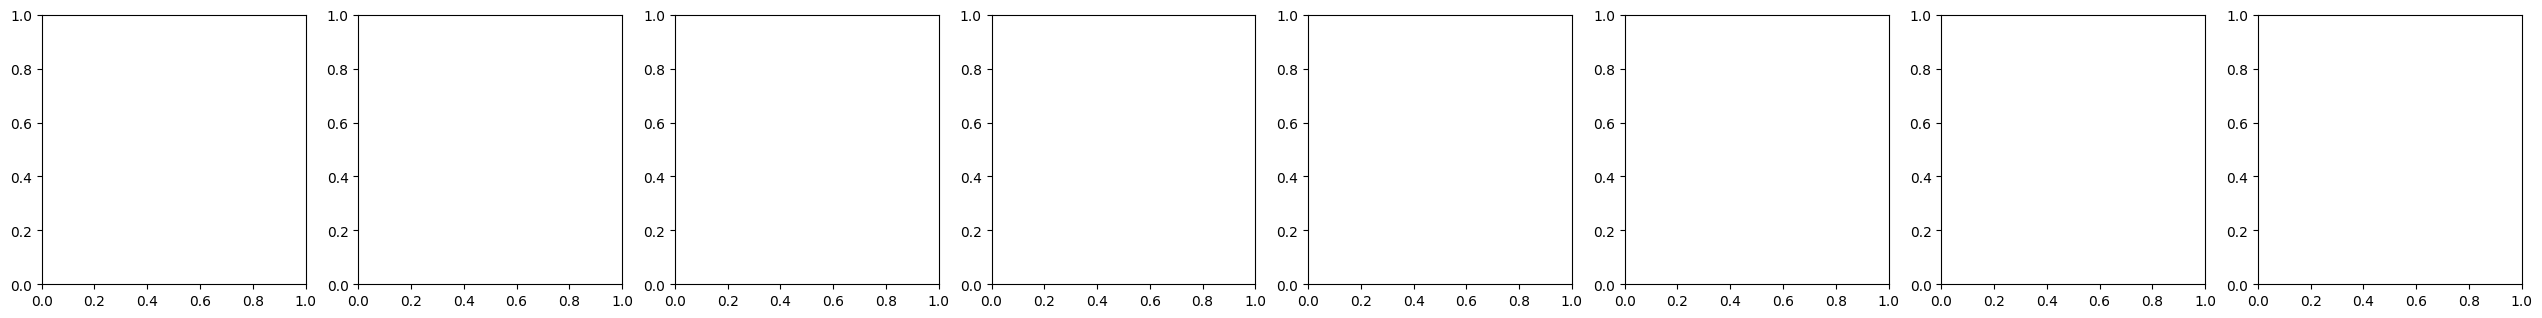

In [37]:
def plot_data_size_ablation(df, agg_ops={}, gen_settings_subset=None, models_subset=None, verbose=False):
    
    group_by_cols = ['model', 'gen_setting', 'ft_data_size']
    if verbose:
        print(f'INDEX COLUMNS: {df.index.names}')
        print(f'GROUPING BY: {group_by_cols}')
        
    dfa = df.groupby(group_by_cols, as_index=True).agg(agg_ops)
    
    # subset
    dfs = dfa.iloc[dfa.index.get_level_values('gen_setting').isin(gen_settings_subset)]
    dfs = dfs.iloc[dfs.index.get_level_values('model').isin(models_subset)]

    # initialize figure
    fig, axes = plt.subplots(nrows=1, ncols=len(agg_ops), figsize=(4*len(agg_ops), 3.5), sharex=True)

    if len(agg_ops) == 1: # non-iterable axes version
        for model, df in dfs.groupby(['model', 'gen_setting']):
            for k in agg_ops.keys():
                if verbose:
                    print(f'Plotting {model} {k} on axis {i} ...')

                x_vals = df.index.get_level_values('ft_data_size').values
                axes.errorbar(
                        x_vals, 
                        df[k]['mean'].values,
                        yerr=df[k]['std'].values,
                        label = model[0], # ' '.join(list(model)),
                        marker = 'o',
                        alpha=0.8,
                        linestyle = '-',
                        # fmt='-o'
                    )

                axes.set_title(f'{k}')
                axes.set_xticks(x_vals)
                axes.legend(frameon=False)
    
    else:
        for model, df in dfs.groupby(['model', 'gen_setting']):
            for ax, k in zip(axes, agg_ops.keys()):
                if verbose:
                    print(f'Plotting {model} {k} on axis {i} ...')

                x_vals = df.index.get_level_values('ft_data_size').values
                ax.errorbar(
                        x_vals, 
                        df[k]['mean'].values,
                        yerr=df[k]['std'].values,
                        label = model[0], # ' '.join(list(model)),
                        marker = 'o',
                        alpha=0.8,
                        linestyle = '-',
                        # fmt='-o'
                    )

                ax.set_title(f'{k}')
                ax.set_xticks(x_vals)
                ax.legend(frameon=False)

    plt.suptitle(f'Generation setting: {", ".join(gen_settings_subset)}')
    
    return

print(f'Dataframe has length: {len(df)}')
# plot_data_size_ablation(df, agg_ops=agg_ops, subset=['default', 'xa_dialog', 'xa_knowledge'])
# plot_data_size_ablation(df, agg_ops={'bleu_t': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['xa_dialog'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['xa_knowledge'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'bleu_t': [np.mean, np.std], 'bleu_k': [np.mean, np.std], 'novelty_k_1gram': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])

plot_data_size_ablation(
    df, 
    agg_ops={
        # 'ppl_mean': [np.mean, np.std],
        # 'uniq': [np.mean, np.std],
        'bleu_t': [np.mean, np.std], 
        'rouge1_k': [np.mean, np.std],
        'rouge1_d': [np.mean, np.std],
        'novelty_k_1gram': [np.mean, np.std], 
        'novelty_d_1gram': [np.mean, np.std],
        'intra_dist1': [np.mean, np.std], 
        'inter_dist1': [np.mean, np.std],
        'qc_turn_level': [np.mean, np.std],
        }, 
    gen_settings_subset=['default'], 
    models_subset=['SI(T5)','SI(MASS)','SI(BART)']
)

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         'ppl_mean': [np.mean, np.std],
#         'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['xa_dialog'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         'ppl_mean': [np.mean, np.std],
#         'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['xa_knowledge'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         'ppl_mean': [np.mean, np.std],
#         'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['xa_dialog+qu_ctxt_aug5'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         'ppl_mean': [np.mean, np.std],
#         'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['xa_knowledge+qu_ctxt_aug5'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )



In [40]:
# import matplotlib.colors as mcolors
# colors = [mcolors.to_hex(plt.cm.tab20(i)) for i in range(20)]
# # patterns = ['', '\\', '+', 'x', '.', '*', 'o', 'O',]
# hpatterns = ['', '\\', '\\\\', '/', '//', '|', '||'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]
# vpatterns = ['', '\\', '\\\\', '/', '//', '-', '--'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]

# def build_bar_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', horizontal: bool = False, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

#     # collect all the data for the relevant target metric first to set min and max vals for all plots
#     data = {}
#     for i, (model, dfx) in enumerate(df.groupby(level=0)):
#         model_results = {}
#         for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=1)):
#             metric_scores = dfx[target_metric].values
#             if min(metric_scores) < min_val:
#                 min_val = min(metric_scores)
#             if max(metric_scores) > max_val:
#                 max_val = max(metric_scores)
#             model_results[gen_setting] = metric_scores
#         data[model] = model_results

#     build_bar(data, horizontal=horizontal, verbose=verbose)
    
#     return


# def build_bar(data: Dict, horizontal: bool = True, verbose: bool = True):

#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#     positions = []
#     means = []
#     stds = []
#     bar_colors = []
#     bar_patterns = []
#     labels = []
    
#     pos = 0
#     for i, (model, gen_settings) in enumerate(data.items()):
#         # TODO make groups for colors and build legend
#         # https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
# #                 group = {model: {}}
#         for j, (gen_setting, scores) in enumerate(gen_settings.items()):

#             labels.append(f'{model} {gen_setting}')
            
#             if not horizontal:
#                 ax.bar(
#                     x = pos,
#                     height = scores.mean(),
#                     yerr=scores.std(), 
#                     color=colors[i],
#                     hatch=vpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             else:
#                 ax.barh(
#                     y = pos,
#                     width = scores.mean(),
#                     xerr=scores.std(), 
#                     color=colors[i],
#                     hatch=hpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             pos += 1 # incrememt pos for next bar
        
#         if not horizontal:
#             ax.set_xticks(np.arange(len(labels)), labels=labels, rotation=45)
#         else:
#             ax.set_yticks(np.arange(len(labels)), labels=labels)
# #         ax.legend()
        
# dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)

# # dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# # build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)




In [ ]:
# agg_ops = {
#     'rouge1_t': np.mean,
#     'rougeL_t': np.mean,
#     'rouge1_k': np.mean,
#     'rougeL_k': np.mean,
#     'rouge1_d': np.mean,
#     'rougeL_d': np.mean,
#     'rouge1_s': np.mean,
#     'rougeL_s': np.mean,
#     'rougeL_s': np.mean,
#     'qc_turn_level': np.mean,
# }

# print(f'Dataframe has length: {len(df)}')
# dfs = df.iloc[df.index.get_level_values('ft_data_size') == 1.0] # select only those entries which use 100% fine-tuning data
# print(f'Dataframe has length: {len(dfs)}')
# dfa = aggregate_values_for_target_metric(dfs, agg_ops=agg_ops)
# dfa
# def plot_rouge(df):
#     df = df.stack().unstack(0)
#     # df = df.reset_index(level=1, drop=True) # re
#     return df
# dfp = plot_rouge(dfa)
# dfp

In [9]:
# OLD PLOTS

# def parse_title(title):
#     title = title.replace('bart_small', '')
#     title = title.replace('(denoising)', '')
#     title = title.replace('(denoising_t5)', 't5-style')
#     return title

# def build_violinplot(data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))

#     if verbose:
#         print('Data:', data)

#     positions = range(1, len(data)+1)[::-1] # reveserse to have defualt at top
#     labels = list(data.keys())[::-1] # reveserse to have defualt at top
    
#     vp1 = ax.violinplot(
#         dataset = list(data.values()),
#         positions=positions,
#         points=30, widths=0.4,
#         showmeans=True, showextrema=True, showmedians=False,
#         vert=False,
#     )
#     if baseline_reference_data:
#         vp2 = ax.violinplot(
#             dataset = list(baseline_reference_data.values()),
#             positions=positions,
#             points=30, widths=0.4,
#             showmeans=True, showextrema=True, showmedians=False,
#             vert=False,
#         )

#         # create legend (currently v. rough)
#         # plt.legend([vp1['bodies'][0], vp2['bodies'][0]], [title, 'default'], loc=2)
        
#     # make title
#     ax.set_title(parse_title(title)) 
    
#     # label yaxis ticks
#     ax.yaxis.set_tick_params(direction='out') 
#     ax.yaxis.set_ticks_position('left')
#     ax.set_yticks(np.arange(1, len(labels) + 1), labels=labels)
# #     ax.set_ylabel('Generation setting')
    
#     # set xaxis limits
#     min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#     max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#     print(f'min={min_val}, max={max_val}')
#     ax.set_xlim(min_val, max_val) #, + 0.75)

#     return fig


# def build_violinplot_subfig(data: Dict, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
    
#     print('BASELINE model provided:', baseline_reference_key)
# #     baseline_reference_data = data.pop(baseline_reference_key) if baseline_reference_key is not None else None
#     baseline_reference_data = data.get(baseline_reference_key)
#     model_array = list(data.keys())
#     print(f'Plotting for models: {model_array}')
    
#     if len(model_array) <= 3:
#         # setup fig based on split arrays 1D
        
#         print('Building single row plots...')
#         nrows = 1
#         ncols = len(model_array)
#         fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
#         for i, model in enumerate(model_array):
            
#             model_results = data[model]

#             if baseline_reference_key is not None and baseline_reference_key != model:
#                 positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
#                 labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
#                 print(f'Plotting {model} on axes at position {i}')
#                 vp1 = axes[i].violinplot(
#                     dataset = list(data[model].values()),
#                     positions=positions,
#                     points=30, widths=0.4,
#                     showmeans=True, showextrema=True, showmedians=False,
#                     vert=False,
#                 )
#                 if baseline_reference_data:
#                     vp2 = axes[i].violinplot(
#                         dataset = list(baseline_reference_data.values()),
#                         positions=positions,
#                         points=30, widths=0.4,
#                         showmeans=True, showextrema=True, showmedians=False,
#                         vert=False,
#                     )
#                 # make title
#                 axes[i].set_title(parse_title(model))

#         # label yaxis ticks
#         axes[0].yaxis.set_tick_params(direction='out') 
#         axes[0].yaxis.set_ticks_position('left')
#         axes[0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#     #     axes[0].set_ylabel('Generation setting')

#     #     # set xaxis limits
#         min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#         max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#         print(f'min={min_val}, max={max_val}')
#         axes[0].set_xlim(min_val, max_val) #, + 0.75)
    
#     else:
#         print('Building multi-row (2D) 3xN plots...')
#         # setup fig based on split arrays 2D
#         if len(model_array) <= 6:
#             nrows = 2
#         elif len(model_array) <= 9:
#             nrows = 3
#         elif len(model_array) <= 12:
#             nrows = 4
        
#         model_array = np.array_split(model_array, nrows)
#         ncols = max([len(a) for a in model_array])
#         fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
#         for i, row in enumerate(model_array):
#             for j, model in enumerate(row):
# #                 if baseline_reference_key is not None and baseline_reference_key != model:
#                 positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
#                 labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
#                 print(f'Plotting {model} on axis at position {i}, {j}')
#                 vp1 = axes[i][j].violinplot(
#                     dataset = list(data[model].values()),
#                     positions=positions,
#                     points=30, widths=0.4,
#                     showmeans=True, showextrema=True, showmedians=False,
#                     vert=False,
#                 )
#                 if baseline_reference_data:
#                     vp2 = axes[i][j].violinplot(
#                         dataset = list(baseline_reference_data.values()),
#                         positions=positions,
#                         points=30, widths=0.4,
#                         showmeans=True, showextrema=True, showmedians=False,
#                         vert=False,
#                     )
#                 # make title
#                 axes[i][j].set_title(parse_title(model))

#             # label yaxis ticks
#             axes[0][0].yaxis.set_tick_params(direction='out') 
#             axes[0][0].yaxis.set_ticks_position('left')
#             axes[0][0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#             # axes[0][0].set_ylabel('Generation setting')

#             # set xaxis limits
#             min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#             max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#             print(f'min={min_val}, max={max_val}')
#             axes[0][0].set_xlim(min_val, max_val) #, + 0.75)

#     plt.suptitle(target_metric)
#     plt.tight_layout()

#     return fig

# def build_violin_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

#     # collect all the data for the relevant target metric first to set min and max vals for all plots
#     data = {}
#     for i, (model, dfx) in enumerate(df.groupby(level=1)):
#         model_results = {}
#         for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=2)):
#             metric_scores = dfx[target_metric].values
#             if min(metric_scores) < min_val:
#                 min_val = min(metric_scores)
#             if max(metric_scores) > max_val:
#                 max_val = max(metric_scores)
#             model_results[gen_setting] = metric_scores
#         data[model] = model_results

#     if verbose:
#         print('Data:')
#         print(data)
        
#     baseline_reference_data = data[baseline_reference_key] if baseline_reference_key is not None else None
    
#     # make violins for each model
#     for model, results in data.items():
#         if baseline_reference_key and baseline_reference_key != model:
#             fig = build_violinplot(results, f'{model} ({target_metric})', baseline_reference_data, min_val, max_val, verbose=verbose)
#             if save:
#                 outpath = str(plot_path / f'{model}-{target_metric}.png')
#                 fig.savefig(outpath, dpi='figure', bbox_inches='tight')
#                 print(f'saved {outpath}')
    
#     # make a subfig for all models
#     fig = build_violinplot_subfig(data, target_metric, baseline_reference_key, min_val, max_val, verbose=verbose)
#     if save:
#         outpath = str(plot_path / f'{baseline_reference_key}_vs_all-{target_metric}.png')
#         fig.savefig(outpath, dpi='figure', bbox_inches='tight')
#         print(f'saved {outpath}')
 
#     return

# # TODO: update!

# # compare bart_base with bart_small
# # dff = df[df.index.isin(['bart_base', 'bart_small(denoising)'], level=0)]
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)

# # # # compare all bart_small models
# # dff = df.iloc[~df.index.get_level_values(1).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
# # print(len(dff))
# # dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=2, axis=0)
# # print(len(dff))
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='MLM+PS', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='MLM+PS', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='MLM+PS', save=True, verbose=False)

# # # # # compare off-the-shelf fine-tuned models
# # dff = df.iloc[df.index.get_level_values(1).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
# # print(len(dff))
# # dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=2, axis=0)
# # print(len(dff))
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='bart_base', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='bart_base', save=True, verbose=False)

